# Models



|            | [1] DeepFold | [2] SeqVec |
|------------|--------------|------------|
| A. DBSCAN  | A1 | A2 |
| B. HDBSCAN | B1 | B2 |
| C. OPTICS  | C1 | C2 |



In [89]:
from utils import gcs_utils as gcs
from utils import model_and_evaluate_cluster as ev

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

import importlib
import hdbscan
from sklearn.cluster import DBSCAN


# Download Embeddings

## 1. DeepFold

In [23]:
prefix = 'embeddings/DeepFold'
keys = gcs.list_file_paths(prefix)

In [25]:
X_deepfold, missing_deepfold, protein_id_full = ev.import_deepfold_embeddings(keys)

embeddings/DeepFold/embeddings_0.csv
embeddings/DeepFold/embeddings_1.csv
embeddings/DeepFold/embeddings_10.csv
embeddings/DeepFold/embeddings_11.csv
embeddings/DeepFold/embeddings_12.csv
embeddings/DeepFold/embeddings_13.csv
embeddings/DeepFold/embeddings_14.csv
embeddings/DeepFold/embeddings_15.csv
embeddings/DeepFold/embeddings_16.csv
embeddings/DeepFold/embeddings_17.csv
embeddings/DeepFold/embeddings_18.csv
embeddings/DeepFold/embeddings_19.csv
embeddings/DeepFold/embeddings_2.csv
embeddings/DeepFold/embeddings_20.csv
embeddings/DeepFold/embeddings_3.csv
embeddings/DeepFold/embeddings_4.csv
embeddings/DeepFold/embeddings_5.csv
embeddings/DeepFold/embeddings_6.csv
embeddings/DeepFold/embeddings_7.csv
embeddings/DeepFold/embeddings_8.csv
embeddings/DeepFold/embeddings_9.csv


In [51]:
print("X_deepfold.shape", X_deepfold.shape)
print("missing_deepfold.shape", missing_deepfold.shape)
print("protein_id_full.shape", protein_id_full.shape)


X_deepfold.shape (20301, 398)
missing_deepfold.shape (203,)
protein_id_full.shape (20301,)


(100, 100)
0.05531216821492077 1.3958603498450148 1.1258949664407183


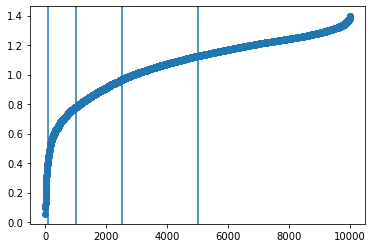

In [32]:
# Show euclidean distances between a random set of points

ed = euclidean_distances(X_deepfold[np.random.choice(range(len(X_deepfold)), 100)],
                         X_deepfold[np.random.choice(range(len(X_deepfold)), 100)]
                        )
print(ed.shape)

min_ed = np.min(ed)
max_ed = np.max(ed)
median_ed = np.median(ed)

print(min_ed, max_ed, median_ed)
ed_flatten = ed.flatten()

plt.scatter(range(len(ed_flatten)), np.sort(ed_flatten))
plt.axvline(len(ed_flatten)/2)
plt.axvline(len(ed_flatten)/4)
plt.axvline(len(ed_flatten)/10)
plt.axvline(len(ed_flatten)/100)
plt.show()

The euclidean distance among the proteins range from 0 to 1.41, median is about 1.12. And based on the plot of euclidean distances, it appears that there are a lot of proteins that are similar to each other and there is a long tail of different proteins. 

## 2. SeqVec

In [55]:
prefix = 'embeddings/SeqVec/'
keys = gcs.list_file_paths(prefix)

# There's only one file 
key = gcs.uri_to_bucket_and_key(keys[1])[1]
seqvec_df = gcs.download_pkl(key)

# Convert pd Series into np arr
X_seqvec = np.stack( seqvec_df["seqvec"]).astype(np.float64)

X_seqvec.shape

(20504, 1024)

# Modeling

## A. DBSCAN

### A.1. DBSCAN + DeepFold

In [49]:
range_eps = np.linspace(start=0.1, stop=1.4, num=6)
range_min_samples = [2, 5, 10]

a1_gridsearch = ev.dbscan_gridsearch(X_deepfold, range_eps, range_min_samples, metric='euclidean')

0.1 2
0.1 5
0.1 10
0.36 2
0.36 5
0.36 10
0.6199999999999999 2
0.6199999999999999 5
0.6199999999999999 10
0.8799999999999998 2
0.8799999999999998 5
0.8799999999999998 10
1.14 2
1.14 5
1.14 10
1.4 2
1.4 5
1.4 10


In [52]:
a1_gridsearch

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
17,1.40,10,euclidean,1,0,20301,None,None,None,None
15,1.40,2,euclidean,1,0,20301,None,None,None,None
14,1.14,10,euclidean,1,0,20301,None,None,None,None
13,1.14,5,euclidean,1,0,20301,None,None,None,None
12,1.14,2,euclidean,1,0,20301,None,None,None,None
16,1.40,5,euclidean,1,0,20301,None,None,None,None
9,0.88,2,euclidean,24,146,20100,1.586657,0.041818,1.117051,0.042953
10,0.88,5,euclidean,1,214,20087,None,None,None,None
11,0.88,10,euclidean,1,258,20043,None,None,None,None
6,0.62,2,euclidean,594,2610,15346,1.355311,-0.131881,1.103202,-0.110608


None of these models look usable because either there's too much noise or too much concentration in one giant cluster. Try again with cosine distance.

In [53]:
# With cosine 
range_eps = np.linspace(start=0.05, stop=0.9, num=5)
range_min_samples = [2, 5, 10]

a1_gridsearch  = ev.dbscan_gridsearch(X_deepfold, range_eps, range_min_samples, metric='cosine')

0.05 2
0.05 5
0.05 10
0.2625 2
0.2625 5
0.2625 10
0.475 2
0.475 5
0.475 10
0.6875 2
0.6875 5
0.6875 10
0.9 2
0.9 5
0.9 10


In [54]:
a1_gridsearch

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
9,0.6875,2,cosine,1,0,20301,None,None,None,None
10,0.6875,5,cosine,1,0,20301,None,None,None,None
11,0.6875,10,cosine,1,0,20301,None,None,None,None
12,0.9000,2,cosine,1,0,20301,None,None,None,None
13,0.9000,5,cosine,1,0,20301,None,None,None,None
14,0.9000,10,cosine,1,0,20301,None,None,None,None
6,0.4750,2,cosine,3,8,20290,2.362348,0.118469,1.023969,0.123562
7,0.4750,5,cosine,1,11,20290,None,None,None,None
8,0.4750,10,cosine,1,11,20290,None,None,None,None
3,0.2625,2,cosine,283,1258,18076,1.404573,-0.093246,1.137328,-0.0843


The least egregious seems to be the modein index `0`, despite a large number of clusters (1,223).

In [90]:
a1_model = DBSCAN(eps=0.0500, 
                  min_samples=2,
                  metric='cosine').fit(X_deepfold)

### A.2. DBSCAN + SeqVec

In [56]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [58]:
range_eps = np.linspace(start=0.1, stop=1.4, num=6)
range_min_samples = [2, 5, 10]

a2_gridsearch = ev.dbscan_gridsearch(X_seqvec, range_eps, range_min_samples, metric='euclidean')

0.1 2
0.1 5
0.1 10
0.36 2
0.36 5
0.36 10
0.6199999999999999 2
0.6199999999999999 5
0.6199999999999999 10
0.8799999999999998 2
0.8799999999999998 5
0.8799999999999998 10
1.14 2
1.14 5
1.14 10
1.4 2
1.4 5
1.4 10


In [59]:
a2_gridsearch

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
15,1.40,2,euclidean,1517,8015,4884,1.362187,-0.146456,1.063184,0.064435
16,1.40,5,euclidean,255,11610,4459,1.452032,-0.185961,1.154683,0.069339
12,1.14,2,euclidean,1733,12610,892,1.340964,-0.189121,0.896392,0.308691
17,1.40,10,euclidean,89,13690,3777,1.503186,-0.170248,1.113373,0.122825
9,0.88,2,euclidean,1337,16042,390,1.264111,-0.290027,0.60572,0.49748
13,1.14,5,euclidean,237,16505,776,1.38767,-0.267331,0.973115,0.309302
14,1.14,10,euclidean,62,18074,603,1.362186,-0.24189,0.867236,0.354841
6,0.62,2,euclidean,730,18402,69,1.155928,-0.382184,0.437564,0.622906
10,0.88,5,euclidean,132,18908,390,1.241584,-0.325762,0.617254,0.515384
11,0.88,10,euclidean,30,19626,389,1.121862,-0.252809,0.564735,0.566048


In [60]:
# With cosine 
range_eps = np.linspace(start=0.05, stop=0.9, num=5)
range_min_samples = [2, 5, 10]

a2_gridsearch  = ev.dbscan_gridsearch(X_seqvec, range_eps, range_min_samples, metric='cosine')

0.05 2
0.05 5
0.05 10
0.2625 2
0.2625 5
0.2625 10
0.475 2
0.475 5
0.475 10
0.6875 2
0.6875 5
0.6875 10
0.9 2
0.9 5
0.9 10


In [61]:
a2_gridsearch

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
6,0.4750,2,cosine,1,0,20504,None,None,None,None
7,0.4750,5,cosine,1,0,20504,None,None,None,None
8,0.4750,10,cosine,1,0,20504,None,None,None,None
9,0.6875,2,cosine,1,0,20504,None,None,None,None
10,0.6875,5,cosine,1,0,20504,None,None,None,None
11,0.6875,10,cosine,1,0,20504,None,None,None,None
12,0.9000,2,cosine,1,0,20504,None,None,None,None
13,0.9000,5,cosine,1,0,20504,None,None,None,None
14,0.9000,10,cosine,1,0,20504,None,None,None,None
3,0.2625,2,cosine,16,72,20367,1.900156,0.020682,1.049466,0.02146


The least aggregious seems to be index 0. That's the same set of params as model a1 with a different embedding.

In [ ]:
a2_model = DBSCAN(eps=0.0500, 
                  min_samples=2,
                  metric='cosine').fit(X_seqvec)

## B. HDBSCAN

`min_cluster_size` [More info](https://readthedocs.org/projects/hdbscan/downloads/pdf/latest/)
> Clusters smaller than this value with be called ‘noise’ and remain unclustered in the resulting flat clustering


`min_samples` [More info](https://readthedocs.org/projects/hdbscan/downloads/pdf/latest/)
>  The simplest intuition for what min_samples does is provide a measure of how conservative
you want you clustering to be. The larger the value of min_samples you provide, the more conservative the
clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas. [...] Note: adjusting min_samples will result in recomputing the hard comptuation of the single linkage
tree.

`cluster_selection_epsilon` [More info](https://hdbscan.readthedocs.io/en/latest/how_to_use_epsilon.html)
> In some cases, we want to choose a small min_cluster_size because even groups of few points might be of interest to us. However, if our data set also contains partitions with high concentrations of objects, this parameter setting can result in a large number of micro-clusters. Selecting a value for cluster_selection_epsilon helps us to merge clusters in these regions. Or in other words, it ensures that clusters below the given threshold are not split up any further.


### B.1. HDBSCAN + DeepFold

In [94]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [ ]:
min_cluster_sizes = [5, 10]
min_samples = [1, 5]
cluster_selection_epsilons = [0, 0.2, 0.3, 0.4]

b1_gridsearch = ev.hdbscan_gridsearch(X_deepfold, 
                                       min_cluster_sizes,
                                       min_samples,
                                       cluster_selection_epsilons
                                      )

In [ ]:
b1_gridsearch

In [92]:
b1_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha=alpha, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric=metric, 
                                     min_cluster_size=min_cluster_size, 
                                     min_samples=min_sample, 
                                     p=None)
clustering.fit(X_deepfold)

### B.2. HDBSCAN + SeqVec

In [ ]:
min_cluster_sizes = [5, 10]
min_samples = [1, 5]
cluster_selection_epsilons = [0, 0.2, 0.3, 0.4]

b2_gridsearch = ev.hdbscan_gridsearch(X_seqvec, 
                                       min_cluster_sizes,
                                       min_samples,
                                       cluster_selection_epsilons
                                      )

In [ ]:
b2_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha=alpha, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric=metric, 
                                     min_cluster_size=min_cluster_size, 
                                     min_samples=min_sample, 
                                     p=None)
clustering.fit(X_seqvec)